density_discrete.ipynb

Discussion: Sampling from a discrete distribution over a square

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 09 November 2016

Author: John Burkardt, Lukas Bystricky

In [1]:
# Import necessary libraries and set plot option
%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial

Using matplotlib backend: agg


# Sampling a discrete distribution #

From our work on sampling and densities, we know that the sampling method
is the key to whether the CVT is uniform or not.  Rather than specifying
a density function rho(x,y), we can modify our sampling technique, as
we did in the circle example, and get a nonuniform result.

We'd like to be able to model population density over a state.  Populations
are not defined by a function, but by chunks of data, that is, so many people
live in this block, and so many in this block, and so on.  Within the block,
we might assume the population density is constant, but from block to block
it must vary.  

In order to do a CVT, we would need to be able, say, to pick 10,000 people
uniformly at random from the population; however, these people would be
distributed nonuniformly with respect to geography.  (We expect a lot
of samples from Miami, but not many from the Everglades!)

To understand how this can be done, we will look at an example that embodies
the same problem, but with simple geometry and only a few sets of data.
So we'll look at a square, which has been subdivided into squares, and for
which the "population" of each subsquare is known.

We will work out a fair way of sampling the population, plot a typical sample,
and then work out how a CVT iteration could be set up for such a problem.
If we understand this problem, then the only difference with Florida is 
a more complicated geometry and larger set of population data.

We will look at:
* reading the population data from a file
* sampling from the population and plotting the sample
* setting up a CVT for this toy problem.

# Our discrete data #

We suppose our "state" is a square in [0,5]x[0,5], divided into a 5x5 array of 
unit squares, which we can think of as 25 counties.  We will find that indexing 
individual counties can be confusing, since sometimes we will want to order them 
by an index running 0 to 24, and other times by double indices running (0,0) to 
(4,4), and other times by the (X,Y) coordinates of the vertices of the corners
of the county.  Let us try to make sense out of this and agree on orderings.
    
Here is how we will index the counties in linear order:

     0  1  2  3  4
     5  6  7  8  9
    10 11 12 13 14
    15 16 17 18 19
    20 21 22 23 24

Here is how we will index the counties in (I,J) or (row,column) order:

    (4,0) (4,1) (4,2) (4,3) (4,4)
    (3,0) (3,1) (3,2) (3,3) (3,4)
    (2,0) (2,1) (2,2) (2,3) (2,4)
    (1,0) (1,1) (1,2) (1,3) (1,4)
    (0,0) (0,1) (0,2) (0,3) (0,4)

Unfortunately, the (X,Y) coordinates of the lower left corner of each county
are in the reverse order, (J,I)!

    (0.0,4.0) (1.0,4.0) (2.0,4.0) (3.0,4.0) (4.0,4.0)
    (0.0,3.0) (1.0,3.0) (2.0,3.0) (3.0,3.0) (4.0,3.0)
    (0.0,2.0) (1.0,2.0) (2.0,2.0) (3.0,2.0) (4.0,2.0)
    (0.0,1.0) (1.0,1.0) (2.0,1.0) (3.0,1.0) (4.0,1.0)
    (0.0,0.0) (1.0,0.0) (2.0,0.0) (3.0,0.0) (4.0,0.0)

Notice that county 13, with (I,J) coordinates (2,3) is inside the
X,Y coordinate box with lower left corner (3.0,2.0) and upper right
corner (4.0,3.0):

    (3.0,3.0)----(4.0,3.0)
        |            |
        |            |
    (3.0,2.0)----(4.0,2.0)
    
which we could also describe as the box [3,4]x[2,3].

Now we supply, for each county, a population, that is, the number of people
who live there.  Here's the data, arranged in the same ordering.  We can imagine 
that the data is measured in thousands, so county 0 has 5,000 inhabitants.

    5  5  2  2  2
    3  3  2  2  2
    3  3  5  5  5
    1  2  5  5 10
    1  2  5 10 10

These numbers add up to 100, so we can see right away that our probability
table, indicating how often we should pick a person from each county is:

    0.05  0.05  0.02  0.02  0.02
    0.03  0.03  0.02  0.02  0.02
    0.03  0.03  0.05  0.05  0.05
    0.01  0.02  0.05  0.05  0.10
    0.01  0.02  0.05  0.10  0.10
    
Now, we have seen this kind of problem before when sampling a triangle of
a polygon before.  What we need now is a running sum of probabilities, so
that we can pick a random number R, and use that to choose at random the
county from which to sample.  If we "read" the counties in the linear order,
then our running sum will look like this:

    0.05  0.10  0.12  0.14  0.16
    0.19  0.22  0.24  0.26  0.28
    0.31  0.34  0.39  0.44  0.49
    0.50  0.52  0.57  0.62  0.72
    0.73  0.75  0.80  0.90  1.00
    
So if our random value R was 0.3173, we would want to pick the county whose
linear index is 11, with (row,column) index (2,1), and (x,y) coordinates
(1.0,2.0) for the lower left corner of the box.



# Using discrete data to do sampling #

Write a function that returns the population data as a list of 25 values;
```python
def pop_data ( ):
  pop = np.array ( [ ... ])
  return pop
```

Write a function that converts the population data into probabilities.
```python
def prob_data ( pop )
  prob = np.array ( [ ... ] )
  return prob
```

Write a function that returns the running sum of the probabilities.
```python
def cdf_data ( prob ):
  cdf = np.array ( [...])
  return cdf
```

Write a function that returns M random samples of the numbers from 0 to 24,
using the CDF data.  That is, this function simply picks a county, with
a weight based on the population.  If we ask for 100 samples, then we'd expect, 
for example, to see county 24 show up about 10 times in the list.
```python
def county_sample_data ( m ):
  county = np.zeros ( m )
  ???
  return county
```


In [11]:
# Code using discrete dagta to do sampling
#
#  Write a function that returns the population data as a list of 25 values;
#
def pop_data ( ):
  pop = np.array ( [ \
    5, 5, 2, 2, 2,\
    3, 3, 2, 2, 2,\
    3, 3, 5, 5, 5,\
    1, 2, 5, 5,10,\
    1, 2, 5,10,10 ] )
  return pop

pop = pop_data ( )
print ( '' )
print ( 'Population data:' )
print ( '' )
print ( pop )
#
#  Write a function that converts the population data into probabilities.
#
def prob_data ( pop ):
  pop_total = np.sum ( pop )
  prob = pop.copy () / float ( pop_total )
  return prob

prob = prob_data ( pop )
print ( '' )
print ( 'Probabilities:')
print ( '' )                    
print ( prob )
                    
#
#  Write a function that returns the running sum of the probabilities.
#
def cdf_data ( prob ):
  cdf = prob.copy ()
  for i in range ( 1, len ( cdf ) ):
    cdf[i] = cdf[i] + cdf[i-1]
  return cdf

cdf = cdf_data ( prob )
print ( '' )                
print ( 'CDF:' )
print ( '' )                    
print ( cdf )
#
#  Write a function that returns M random samples of the numbers from 0 to 24,
#  using the CDF data.  That is, this function simply picks a county, with
#  a weight based on the population.  If we ask for 100 samples, then we'd expect, 
#  for example, to see county 24 show up about 10 times in the list.
#
def county_sample_data ( m ):
  county = -1 * np.ones( m )
  for j in range ( 0, m ):
    r = np.random.rand ( )
    for i in range ( 0, 25 ):
      if ( r < cdf[i] ):
        county[j] = i
        break
  return county

m = 100
county = county_sample_data ( m )
county.sort()
print ( '' )
print ( 'County data (sorted)')
print ( '' )
print ( county )


Population data:

[ 5  5  2  2  2  3  3  2  2  2  3  3  5  5  5  1  2  5  5 10  1  2  5 10 10]

Probabilities:

[ 0.05  0.05  0.02  0.02  0.02  0.03  0.03  0.02  0.02  0.02  0.03  0.03
  0.05  0.05  0.05  0.01  0.02  0.05  0.05  0.1   0.01  0.02  0.05  0.1
  0.1 ]

CDF

[ 0.05  0.1   0.12  0.14  0.16  0.19  0.22  0.24  0.26  0.28  0.31  0.34
  0.39  0.44  0.49  0.5   0.52  0.57  0.62  0.72  0.73  0.75  0.8   0.9   1.  ]

County data (sorted)

[  0.   0.   0.   0.   0.   0.   1.   1.   2.   3.   3.   3.   3.   3.   4.
   4.   4.   4.   4.   5.   5.   5.   6.   6.   6.   6.   6.   6.   6.   7.
   7.   7.   7.   8.   9.  11.  11.  11.  12.  12.  12.  13.  13.  13.  13.
  13.  14.  14.  14.  14.  14.  14.  15.  16.  16.  16.  17.  17.  17.  18.
  18.  19.  19.  19.  19.  19.  19.  19.  19.  19.  19.  21.  21.  22.  22.
  22.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.  23.
  23.  24.  24.  24.  24.  24.  24.  24.  24.  24.]


# Pick a random person from the random county #

Suppose we wanted to pick a single person uniformly at random from the 100,000
people in the state?  

Step 1 is to pick a county at random.  We did that with the county_sample_data()
function.  But once we have a county, we have to pick a person.  Suppose, for
instance, that we have picked county 13, which we know is in the box with
corners (3,2) and (4,3).

Assuming we have no better information, we simply want to pick a random point in
this box as the site of this random person.  So we have to pick random r1 and r2
between 0 and 1, and rescale them to an x and a y in the box.

    x = 3 + ( 4 - 3 ) * r1
    y = 2 + ( 3 - 2 ) * r2
    
So to do this in general, we need to be able to go from a county index, such
as 13, to the row and column indices, (2,3), to the coordinates of the lower
left and upper right corners of the box, (3.0,2.0) and (4.0,3.0).  

Given a county index, such as 13, produce the row and column of the county,
(2,3) in this case, where the rows go from 4 down to 0, and the columns 
rise from 0 to 4:
```python
def county_row_column ( index )
  ???
  return row, column
```
Given a county index, such as 13, produce the coordinates 
of the lower left corner (x1,y1) and the upper right corner (x2,y2) of the county,
which in this case would be (3.0,2.0) and (4.0,3.0):
```python
def county_corners ( row, col ):
  ???
  return x1, y1, x2, y2
```

Given a county index, such as 13, produce a random point inside that county,
which might be (3.14,2.79)
```python
def county_sample ( index )
  ???
  return x, y
```

In [21]:
# Code to pick a random person

def county_row_column ( index ):
  k = 0
  for row in range ( 4, -1, -1 ):
    for column in range ( 0, 5 ):
      if ( k == index ):
        return row, column
      k = k + 1
  return row, column

index = 13
row, column = county_row_column ( index )
print ( '' )
print ( '  For index %d, row = %d, column = %d' % ( index, row, column ) )
    
def county_corners ( index ):
  row, column = county_row_column ( index )
  x1 = float ( column )
  y1 = float ( row )
  x2 = x1 + 1.0
  y2 = y1 + 1.0
  return x1, y1, x2, y2

x1, y1, x2, y2 = county_corners ( index )
print ( '  For index %d, lower left corner = (%g,%g), upper right = (%g,%g)' \
  % ( index, x1, y1, x2, y2 ) )

def county_sample ( index ):
  x1, y1, x2, y2 = county_corners ( index )
  r1 = np.random.rand ( )
  r2 = np.random.rand ( )
  x = x1 + ( x2 - x1 ) * r1
  y = y1 + ( y2 - y1 ) * r2
  return x, y

print ( '' )
print ( 'Five sample points from county 13:')
for i in range ( 0, 5 ):
  x, y = county_sample ( index )
  print ( '  (%g,%g)' % ( x, y ) )


  For index 13, row = 2, column = 3
  For index 13, lower left corner = (3,2), upper right = (4,3)

Five sample points from county 13:
  (3.44768,2.41223)
  (3.27209,2.40767)
  (3.76894,2.43551)
  (3.96072,2.49167)
  (3.52386,2.47286)


# Compute and plot a random sample #

So to pick the location of a random person in the state, according to
the discrete density information we were given to start with, we need
to first select uniformly at random the county, and then select uniformly
at random a location in the county.

Compute 1,000 samples from the state, and plot them.

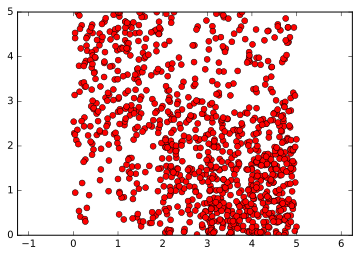

In [25]:
# Code to compute and plot a random sample

m = 1000
s = np.zeros ( [ m, 2 ] )
c = county_sample_data ( m )

for i in range ( 0, m ):
  index = c[i]
  x, y = county_sample ( index )
  s[i,:] = [ x, y ]

plt.plot ( s[:,0], s[:,1], 'ro' )
plt.axis ( 'Equal' )
plt.show ( )